# **LSTM-Stock Prediction**
## Import the necessary libraries

In [1]:
!pip install pandas_datareader==0.9.0
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: pandas_datareader
    Found existing installation: pandas-datareader 0.10.0
    Uninstalling pandas-datareader-0.10.0:
      Successfully uninstalled pandas-datareader-0.10.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import datetime as dt

## Specifies the stock symbol number for the prediction
If you want to predict the stock in US market, type:
`company='the name of the company' `

for exmaple: `company='AAPL' #which stands for Apple `

In [3]:
#The specifies stock symbol for a Taiwanese company.
company = '2002.TW'

data_start= dt.datetime(2020,1,1)
data_end = dt.datetime(2024,2,29)

#Download the data from yahoo finance
data = yf.download(company, data_start, data_end)
print(data.head(5))
print(data.tail(5))


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-01-02  24.000000  24.100000  23.900000  24.000000  20.218719   6939981
2020-01-03  24.049999  24.100000  23.950001  24.100000  20.302965  12353288
2020-01-06  24.000000  24.049999  23.799999  23.799999  20.050230   7042674
2020-01-07  23.799999  23.900000  23.700001  23.700001  19.965986   7693624
2020-01-08  23.700001  23.700001  23.500000  23.549999  19.839619   9093876
                 Open       High    Low  Close  Adj Close    Volume
Date                                                               
2024-02-21  25.299999  25.299999  25.15  25.25      25.25   9525441
2024-02-22  25.250000  25.299999  25.10  25.15      25.15   9676925
2024-02-23  25.150000  25.200001  25.00  25.00      25.00  11649661
2024-02-26  24.900000  25.000000  24.90  24.90      24.90  11512246
2024-02-27  24.799999  24.799999  24.60  24.65      24.65  2

In [4]:
##Determine the columns(the input/parameter you want for prediction) of the data##
df=data[['Close']]
print(df.head())
print(f'df_shape{df.shape}')

                Close
Date                 
2020-01-02  24.000000
2020-01-03  24.100000
2020-01-06  23.799999
2020-01-07  23.700001
2020-01-08  23.549999
df_shape(1007, 1)


Text(0.5, 1.0, 'Stock Price Over Time')

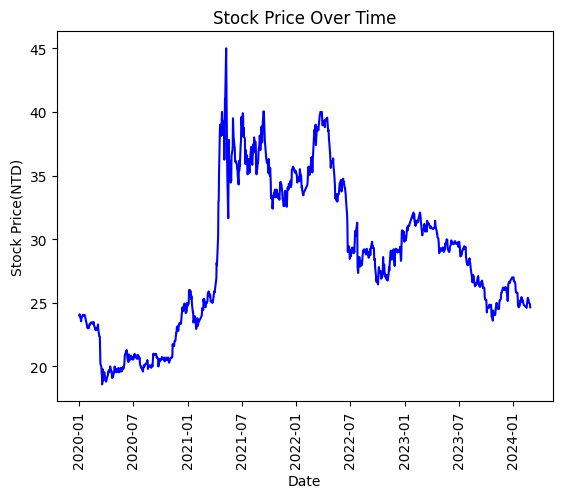

In [5]:
#Print the plot for visualization
plt.plot(df, color="blue")
plt.tick_params(axis ='x', rotation = 90)
plt.xlabel('Date')  # Add x-axis label
plt.ylabel('Stock Price(NTD)')  # Add y-axis label
plt.title('Stock Price Over Time')  # Add plot title


#Data Preprocessing

*   **MinMaxScaler:**
MinMaxScaler is one of the data preprocessing technique, it scales the features into a range from 0 to 1, which could increase the speed when the model computing the data, instead of computing a bunch of large integers during training, the formula can be represented as the following equation.

\begin{align}
 X_{\text{scaled}}= \frac{{X - X_{\text{min}}}}{{X_{\text{max}} - X_{\text{min}}}}
\end{align}

where:
- $X$ is the original feature value,
- $X_{\text{min}}$ is the minimum value of the feature,
- $X_{\text{max}}$ is the maximum value of the feature,
- $X_{\text{scaled}}$ is the after scaled value.


In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
##Scale the data##
df_scaler = MinMaxScaler(feature_range =(0,1))
df_scaled = df_scaler.fit_transform(df)

print(df_scaled[:5])
print(f'df_scaled_shape{df_scaled.shape}')


[[0.20454544]
 [0.20833334]
 [0.19696966]
 [0.19318184]
 [0.18749996]]
df_scaled_shape(1007, 1)


#Spilt the data
To split the stock price data into training and testing sets, we're using a **Time Series** approach instead of a random split.

In this project, the `train_split` is set to 70%, and 30% for the `test_split`

In [8]:
print(len(df_scaled))

train_split = int(0.7 * len(df_scaled))
test_split = int(0.3 * len(df_scaled))

print(train_split)
print(test_split)

1007
704
302


In [9]:
# Split the data into training and testing sets based on the split date
train_data = df_scaled[:train_split]
test_data=df_scaled[train_split:]

# print(train_data)
print(len(train_data))
print(len(test_data))

print(f'train_data:{train_data[:5]}')
print(f'test_data:{test_data[:5]}')

704
303
train_data:[[0.20454544]
 [0.20833334]
 [0.19696966]
 [0.19318184]
 [0.18749996]]
test_data:[[0.39393939]
 [0.39393939]
 [0.39393939]
 [0.40151517]
 [0.38446969]]


#Time step in LSTM
In this project, the prediction days is set to 5 days,
`prediction_days = 5`, which means that the model will predict the next day's stock price, based on the past 5 days.



*   **Smaller time step(e.g., 3d days):** Caputure the short-term trend, but it may be less stable and more sensitive to noise in the data.
*   **Larger time step(e.g., 10d days):** Caputure the long-term trend, but it may be less sensitive to the data, and missed the important sign in the trend.



In [10]:
#Set up the time step
prediction_days = 5

##train_data##
x_train = []
y_train = []
#so the x will start from 5, from 5 to the len of train_data
for x in range(prediction_days, len(train_data)):
  x_train.append(train_data[x-prediction_days:x,0:])
  y_train.append(train_data[x,0])

##test_data##
x_test = []
y_test = []

for x in range(prediction_days, len(test_data)):
  x_test.append(test_data[x-prediction_days:x,0:])
  y_test.append(test_data[x,0])

print (x_train[:2])
print (y_train[:2])

print (x_test[:2])
print (y_test[:2])
print(type(x_train))
print(type(y_train))


[array([[0.20454544],
       [0.20833334],
       [0.19696966],
       [0.19318184],
       [0.18749996]]), array([[0.20833334],
       [0.19696966],
       [0.19318184],
       [0.18749996],
       [0.19507575]])]
[0.19507574594491528, 0.19886363923713857]
[array([[0.39393939],
       [0.39393939],
       [0.39393939],
       [0.40151517],
       [0.38446969]]), array([[0.39393939],
       [0.39393939],
       [0.40151517],
       [0.38446969],
       [0.3522727 ]])]
[0.352272703463709, 0.3825757775534395]
<class 'list'>
<class 'list'>


In [11]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

699
699
298
298


#Specific format of the data for feeding into LSTM
LSTM models expect input data in a specific format, usually in the shape (samples, time steps, features)


In [12]:
#Turns the List into Numpy array to feed into the LSTM model.
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

# (number_of_samples, number_of_time_steps, number_of_features)
print(f'x_train.shape{x_train.shape}')
print(f"y_train.shape{y_train.shape}")

print(f"x_test.shape{x_test.shape}")
print(f"y_test.shape{y_test.shape}")

print(type(x_train))
print(type(y_train))

x_train.shape(699, 5, 1)
y_train.shape(699,)
x_test.shape(298, 5, 1)
y_test.shape(298,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#LSTM
### Model Architecture

*   **First input layer**: have 150 neurons, input parameter, and a returning sequences (output for each time step), with an activation function as 'relu'
*   **Second layer**: have 150 neurons, returning sequences (output for each time step), using ReLU activation.
*   **Third layer**: have 150 neurons, not returning sequences (output only at the last time step), using ReLU activation.
*   **Final/Output layer**: have 1 neurons, due to there is only 1 expecting output for this model prediction, using Linear activation.
*   **Dropout layer**: Dropout layers are added after each LSTM layer to prevent overfitting

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam,SGD

Epoch 1/100
35/35 [==============================] - 10s 95ms/step - loss: 0.0963 - val_loss: 0.0054
Epoch 2/100
35/35 [==============================] - 2s 50ms/step - loss: 0.0118 - val_loss: 0.0012
Epoch 3/100
35/35 [==============================] - 2s 58ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 4/100
35/35 [==============================] - 3s 81ms/step - loss: 0.0055 - val_loss: 4.4613e-04
Epoch 5/100
35/35 [==============================] - 2s 54ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 6/100
35/35 [==============================] - 2s 45ms/step - loss: 0.0058 - val_loss: 6.8816e-04
Epoch 7/100
35/35 [==============================] - 2s 55ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 8/100
35/35 [==============================] - 2s 47ms/step - loss: 0.0051 - val_loss: 9.1365e-04
Epoch 9/100
35/35 [==============================] - 2s 56ms/step - loss: 0.0047 - val_loss: 4.3382e-04
Epoch 10/100
35/35 [==============================] - 2s 60ms/step - loss: 0.0050 -

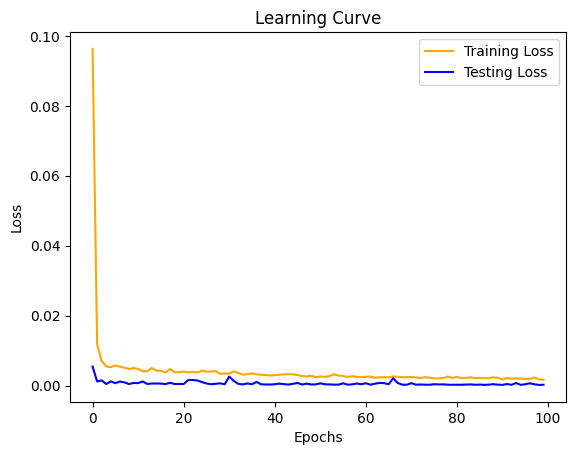

In [14]:
###LSTM model

# input shape=(times step, input features)
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(units=150, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

#After the analysis for the model performance, The optimizer of Adam and 20batch, 100epochs have the lowest loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history=model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=20, epochs=100, verbose=1)

#Store the loss
train_loss=history.history['loss']
test_loss=history.history['val_loss']

#plot learning rate for train and test data
plt.plot(train_loss, label='Training Loss', color='orange')
plt.plot(test_loss, label='Testing Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


#Evaluation Metrics

**1. MSE(Mean Square Error):**


*   An evaluation metrics which suitable for the **regression problem**.
*   The smaller value of the MSE, indicates the better performance of the model, as they represent an error with the actual and predict output.
*   MSE could be shown as the following equation, where ${n}$ represent the number of data points;  ${y_i}$ represent the actual output,  $\hat{y_i}$ represent the predict output.

\begin{align}
 \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{align}


**2. R-squared:**
*   R-squared value is commonly range from 0 to 1, which could be understand as from 0% to 100%.
*   Commonly, the higher value of R-square indicated a better model fits, but its still need to depend on what or which data/problem that the model is dealing with.
*   R-squared could be shown as the following equation, where ${SSR}$ is the sum of squared residuals (errors) and ${SST}$ is the total sum of squares (variation in the target).
\begin{align}
 \text{R}^2 = 1-\frac{SSR}{SST}
\end{align}



In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


22/22 [==============================] - 1s 9ms/step
mse_train:0.0007540545697249753
r2_train:0.9886249399158185

prediction_train:[[0.18377571]]
y_orig_train:[0.19507575]
prediction_train.shape:(699, 1)
y_train.shape:(699,)

y_train_reshape.shape:(699, 1)

prediction_train_scaled:[[23.45168]]
y_train_scaled:[[23.75]]


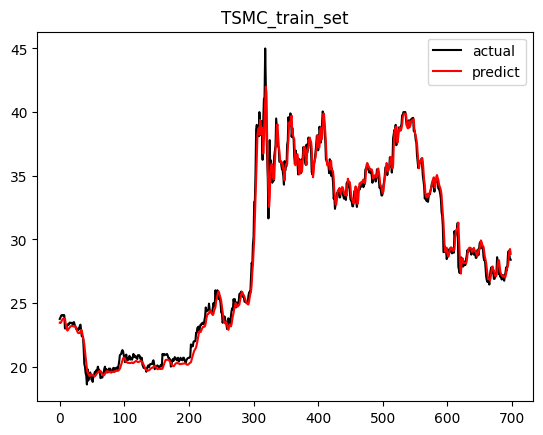

In [17]:
#Model make prediction for training data
prediction_train=model.predict(x_train)
mse_train=mean_squared_error(y_train, prediction_train)
r_square_train= r2_score(y_train, prediction_train)
print(f'mse_train:{mse_train}')
print(f'r2_train:{r_square_train}\n')


print(f"prediction_train:{prediction_train[:1]}")
print(f"y_orig_train:{y_train[:1]}")
# print(f"y_train_orig_scaled:{y_train_scaled[:1]}")

# y_train_orig_scaled=y_scaler.inverse_transform(y_train)

print(f"prediction_train.shape:{prediction_train.shape}")
print(f"y_train.shape:{y_train.shape}\n")

y_train_reshape=y_train.reshape(-1,1)
print(f"y_train_reshape.shape:{y_train_reshape.shape}\n")

prediction_train_scaled=df_scaler.inverse_transform(prediction_train)
y_train_scaled=df_scaler.inverse_transform(y_train_reshape)

print(f"prediction_train_scaled:{prediction_train_scaled[:1]}")
print(f"y_train_scaled:{y_train_scaled[:1]}")

plt.plot(y_train_scaled, color='black', label=f'actual')
plt.plot(prediction_train_scaled, color='red', label=f'predict')
plt.title(f"TSMC_train_set")
plt.legend()

# plt.xlim(990, 1000)  # Set the limits for the x-axis
# plt.ylim(100, 300)  # Set the limits for the y-axis

plt.show()

10/10 [==============================] - 0s 8ms/step
prediction:[[0.39681593]]
y_test:[0.3522727]

mse_test:0.00023169786448431844
r_square_test:0.9710887611303947

prediction.shape:(298, 1)
y_test.shape:(298,)

y_test_reshape.shape:(298, 1)

y_test_prediction:[[29.075941]]
y_test_scaled:[[27.89999962]]


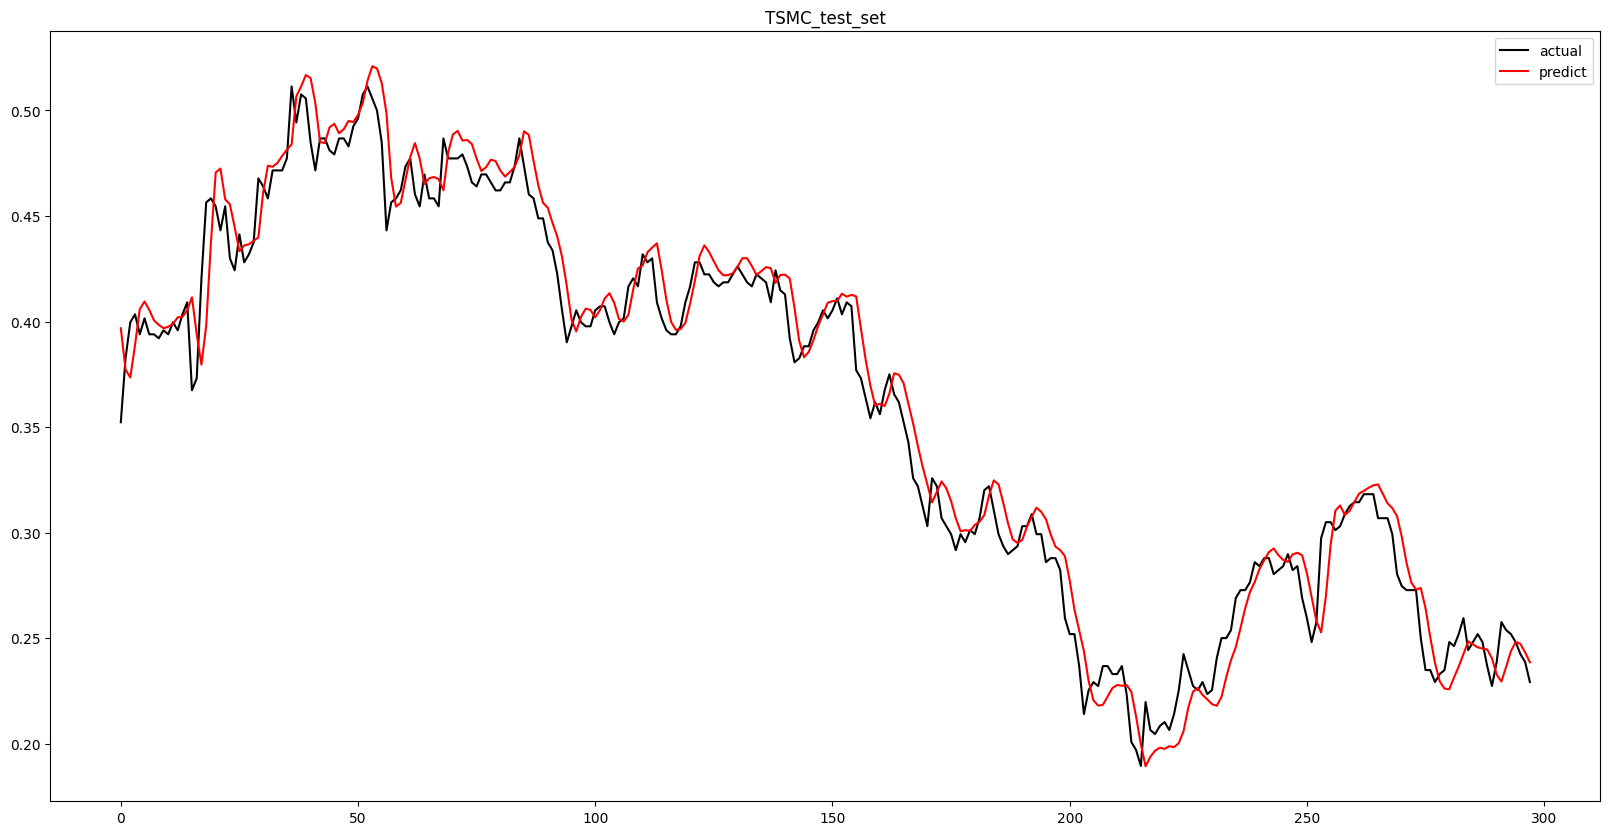

In [18]:
prediction=model.predict(x_test)

print(f"prediction:{prediction[:1]}")
print(f"y_test:{y_test[:1]}\n")

mse_test=mean_squared_error(y_test, prediction)
r_square_test= r2_score(y_test, prediction)
print(f'mse_test:{mse_test}')
print(f'r_square_test:{r_square_test}\n')

print(f"prediction.shape:{prediction.shape}")
print(f"y_test.shape:{y_test.shape}\n")

#reshape the y_test so can inverse transform
y_test_reshape = y_test.reshape(-1,1)
print(f"y_test_reshape.shape:{y_test_reshape.shape}\n")

#scaled back the orig number
y_test_prediction= df_scaler.inverse_transform(prediction)
y_test_scaled= df_scaler.inverse_transform(y_test_reshape)

print(f"y_test_prediction:{y_test_prediction[:1]}")
print(f"y_test_scaled:{y_test_scaled[:1]}")

plt.figure(figsize=(20,10))
plt.plot(y_test, color='black', label=f'actual')
plt.plot(prediction, color='red', label=f'predict')
plt.title(f"TSMC_test_set")
plt.legend()


# plt.xlim(250, 350)  # Set the limits for the x-axis
# plt.ylim(0, 1)  # Set the limits for the y-axis
plt.show()

In [19]:
# print(df_scaled[558:])
print(df_scaled.shape)

# Initialize a list to store the predicted prices
predicted_prices = []

#take the last sequence
number_of_days=5
last_sequence = df_scaled[-number_of_days:]
print(last_sequence)
print(last_sequence.shape)
print(f'this{last_sequence.shape[1]}')

# (number_of_samples, number_of_time_steps, number_of_features)
last_sequence_reshape= last_sequence.reshape(1,number_of_days,last_sequence.shape[1])
print(last_sequence_reshape.shape)
print(last_sequence_reshape)




(1007, 1)
[[0.25189393]
 [0.24810604]
 [0.24242423]
 [0.23863634]
 [0.22916664]]
(5, 1)
this1
(1, 5, 1)
[[[0.25189393]
  [0.24810604]
  [0.24242423]
  [0.23863634]
  [0.22916664]]]


In [20]:
###For 1 day prediction
# next_day_prediction = model.predict(last_sequence_reshape)
# print(next_day_prediction)
# # Append the prediction to the list
# last_sequence=np.append(last_sequence,next_day_prediction)
# print(f'last_sequence{last_sequence}')
# new_last_sequence=last_sequence[1:]
# print(f'new_last_sequence{new_last_sequence}')
# print(f'new_last_sequence.shape{new_last_sequence.shape}')
# new_last_sequence_reshape=new_last_sequence.reshape(1,prediction_days,1)
# print(f'new_last_sequence_reshape.shape{new_last_sequence_reshape.shape}')
# last_sequence_reshape=new_last_sequence_reshape
# print(f'last_sequence_reshape{last_sequence_reshape}')


In [21]:
future_pred=[]

for _ in range(10):
  next_day_prediction = model.predict(last_sequence_reshape)
  # Append the prediction to the list
  last_sequence=np.append(last_sequence,next_day_prediction)
  new_last_sequence=last_sequence[-number_of_days:]
  new_last_sequence_reshape=new_last_sequence.reshape(1,number_of_days,1)
  last_sequence_reshape=new_last_sequence_reshape
  next_day_prediction_inverse=df_scaler.inverse_transform(next_day_prediction)
  future_pred.append(next_day_prediction_inverse.flatten())

  print(f'next_day_prediction{next_day_prediction}')
  print(f'next_day_prediction_inverse{df_scaler.inverse_transform(next_day_prediction)}')


1/1 [==============================] - 0s 43ms/step
next_day_prediction[[0.23209116]]
next_day_prediction_inverse[[24.727207]]
1/1 [==============================] - 0s 36ms/step
next_day_prediction[[0.2276134]]
next_day_prediction_inverse[[24.608994]]
1/1 [==============================] - 0s 34ms/step
next_day_prediction[[0.22397488]]
next_day_prediction_inverse[[24.512938]]
1/1 [==============================] - 0s 37ms/step
next_day_prediction[[0.22054964]]
next_day_prediction_inverse[[24.422512]]
1/1 [==============================] - 0s 33ms/step
next_day_prediction[[0.216731]]
next_day_prediction_inverse[[24.321697]]
1/1 [==============================] - 0s 33ms/step
next_day_prediction[[0.21263102]]
next_day_prediction_inverse[[24.213459]]
1/1 [==============================] - 0s 49ms/step
next_day_prediction[[0.20839047]]
next_day_prediction_inverse[[24.10151]]
1/1 [==============================] - 0s 40ms/step
next_day_prediction[[0.20400624]]
next_day_prediction_inverse[[

[*********************100%%**********************]  1 of 1 completed


                Close
Date                 
2024-02-29  24.600000
2024-03-01  24.450001
2024-03-04  24.200001
2024-03-05  24.049999
2024-03-06  24.049999
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[array([24.727207], dtype=float32), array([24.608994], dtype=float32), array([24.512938], dtype=float32), array([24.422512], dtype=float32), array([24.321697], dtype=float32), array([24.213459], dtype=float32), array([24.10151], dtype=float32), array([23.985764], dtype=float32), array([23.864643], dtype=float32), array([23.742441], dtype=float32)]


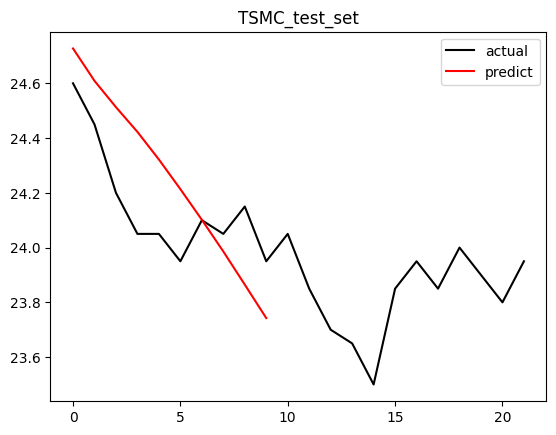

In [22]:

test_data_start= dt.datetime(2024,2,29)
test_data_end = dt.datetime(2024,4,1)
predi_data = yf.download(company, test_data_start, test_data_end)
##determine the columns of data##
df=predi_data[['Close']]
print(df.head())

print(type(next_day_prediction))
print(type(df))

array = df.values

# print(array)
print(type(array))
print(future_pred)

plt.plot(array, color='black', label=f'actual')
plt.plot(future_pred, color='red', label=f'predict')
plt.title(f"TSMC_test_set")
plt.legend()
plt.show()
